In [1]:
# %reset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import itertools
import seaborn as sns
# import Eval_Metrics
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier # for random forest classifier
from scipy.stats import randint as sp_randint
from time import time

%matplotlib inline
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

import warnings
warnings.filterwarnings('ignore')

### Train set values

In [3]:
data_train_value = pd.read_csv('C:/Users/sbadretale/Desktop/Driven Data/Pump it Up Data Mining the Water Table/Training set values.csv')

print('Number of records: ' ,data_train_value.shape[0])
print("----------  ".format(""))
print('Number of features : ' ,data_train_value.shape[1])
data_train_value.head(5)

Number of records:  59400
----------  
Number of features :  40


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


### Train set labels

In [4]:
data_train_label = pd.read_csv('C:/Users/sbadretale/Desktop/Driven Data/Pump it Up Data Mining the Water Table/Training set labels.csv')

print('Number of records: ' ,data_train_label.shape[0])
print("----------  ".format(""))
print('Number of features : ' ,data_train_label.shape[1])
data_train_label.head(5)

Number of records:  59400
----------  
Number of features :  2


,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


### Train set 

In [5]:
data_train = pd.merge(data_train_value, data_train_label, on=['id'])
data_train.head(5)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


status_group
functional                 32259
functional needs repair     4317
non functional             22824
Name: status_group, dtype: int64

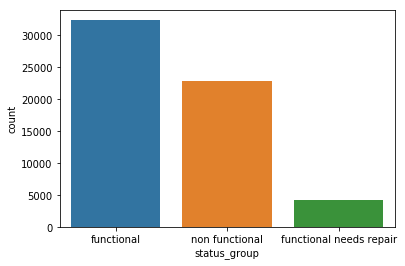

In [6]:
ax = sns.countplot(data_train['status_group'] , label = "Count")  
data_train.groupby('status_group')['status_group'].count()

### Lets plot the Histogram of Time 

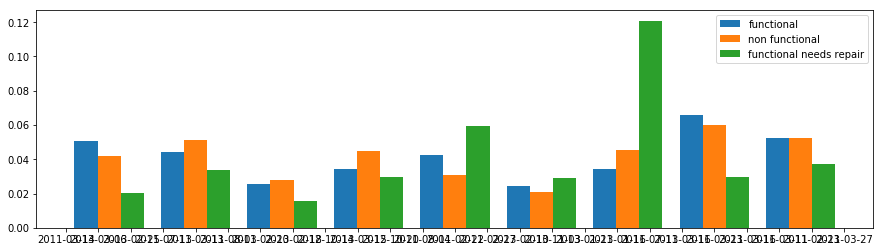

In [7]:
fig = plt.figure(figsize=(15,4))
plt.hist( [ data_train.loc[ data_train['status_group']=='functional', 'date_recorded'], 
          data_train.loc[ data_train['status_group']=='non functional', 'date_recorded'], 
          data_train.loc[ data_train['status_group']=='functional needs repair', 'date_recorded']],
         normed=True, label=['functional','non functional', 'functional needs repair'], bins=np.linspace(0,24,10))
plt.legend()
plt.show()

### Test set 

In [8]:
data_test = pd.read_csv('C:/Users/sbadretale/Desktop/Driven Data/Pump it Up Data Mining the Water Table/Test set values.csv')

print('Number of records: ' ,data_test.shape[0])
print("----------  ".format(""))
print('Number of features : ' ,data_test.shape[1])
data_test.head(5)

Number of records:  14850
----------  
Number of features :  40


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,04/02/2013,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,04/02/2013,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,01/02/2013,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,22/01/2013,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,27/03/2013,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


### Concatenate train and test set for pre-processing

In [9]:
data_train_test = pd.concat([data_train_value, data_test], axis=0)

print('Number of records: ' ,data_train_test.shape[0])
print("----------  ".format(""))
print('Number of features : ' ,data_train_test.shape[1])
data_train_test.head(5)

Number of records:  74250
----------  
Number of features :  40


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [10]:
# Check to see if there are any missing values in our data set

total = data_train_test.isnull().sum().sort_values(ascending = False)
percent = (data_train_test.isnull().sum()/data_train_test.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total out of 74250 records', 'Percent'])

,Total out of 74250 records,Percent
scheme_name,35258,47.485522
scheme_management,4846,6.526599
installer,4532,6.103704
funder,4504,6.065993
public_meeting,4155,5.595960
permit,3793,5.108418
subvillage,470,0.632997
ward,0,0.000000
lga,0,0.000000
district_code,0,0.000000


In [11]:
print('How many records (rows) have missing values out of 74250 records ?\n', data_train_test[data_train_test.isnull().any(axis=1)].shape[0])

How many records (rows) have missing values out of 74250 records ?
 39493


In [12]:
print('Number of distinct elements in "scheme name" is:\n '  ,len(list(set(data_train_test.scheme_name))))
print('Number of distinct elements in "scheme_management" is:\n '  ,len(list(set(data_train_test.scheme_management))))
print('Number of distinct elements in "installer" is:\n '  ,len(list(set(data_train_test.installer))))
print('Number of distinct elements in "funder" is:\n '  ,len(list(set(data_train_test.funder))))
print('Number of distinct elements in "public_meeting" is:\n '  ,len(list(set(data_train_test.public_meeting))))
print('Number of distinct elements in "permit" is:\n '  ,len(list(set(data_train_test.permit))))
print('Number of distinct elements in "subvillage" is:\n '  ,len(list(set(data_train_test.subvillage))))

Number of distinct elements in "scheme name" is:
  2869
Number of distinct elements in "scheme_management" is:
  13
Number of distinct elements in "installer" is:
  2411
Number of distinct elements in "funder" is:
  2141
Number of distinct elements in "public_meeting" is:
  3
Number of distinct elements in "permit" is:
  3
Number of distinct elements in "subvillage" is:
  21426


### I will delete the column "scheme_name' since %48 of data is missing and for the rest of the columns with missing values, I will fill with zero, except for 'public_meeting' and 'permit' which are the binary features.

In [13]:
data_train_test = data_train_test.drop(['scheme_name'], axis=1)

In [14]:
data_train_test = data_train_test .fillna({'scheme_management':0,'installer':0, 'funder':0, 'public_meeting':2,
                                          'permit':2, 'subvillage':0})

In [15]:
# Duplicate rows? No

print('Number of duplicate records are :\n' , 
      sum( data_train_test.drop(
          columns=['scheme_management', 'installer', 'funder', 'public_meeting', 'permit', 'subvillage'] ).duplicated() ))

Number of duplicate records are :
 0


### Finding the type of each feature: Numerical and Categorical features

In [16]:
data_train_test.columns.to_series().groupby(data_train_test.dtypes).groups

{dtype('int64'): Index(['id', 'gps_height', 'num_private', 'region_code', 'district_code',
        'population', 'construction_year'],
       dtype='object'),
 dtype('float64'): Index(['amount_tsh', 'longitude', 'latitude'], dtype='object'),
 dtype('O'): Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
        'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
        'scheme_management', 'permit', 'extraction_type',
        'extraction_type_group', 'extraction_type_class', 'management',
        'management_group', 'payment', 'payment_type', 'water_quality',
        'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
        'source_class', 'waterpoint_type', 'waterpoint_type_group'],
       dtype='object')}

"public_meeting" feature is consist of:  [False, True, 2]


Text(0.5,1,'"public_meeting" Distribution in Train set')

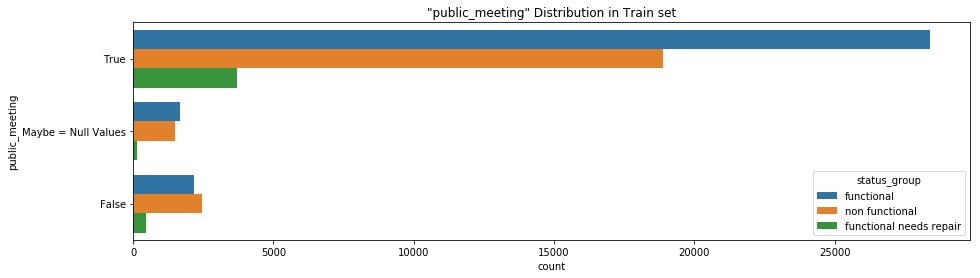

In [17]:
print('"public_meeting" feature is consist of: '  ,list(set(data_train_test.public_meeting)))
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y="public_meeting", hue=data_train['status_group'], data= data_train[['public_meeting']].fillna('Maybe = Null Values')).set_title('"public_meeting" Distribution in Train set')

"permit" feature is consist of:  [False, True, 2]


Text(0.5,1,'"permit" Distribution in Train set')

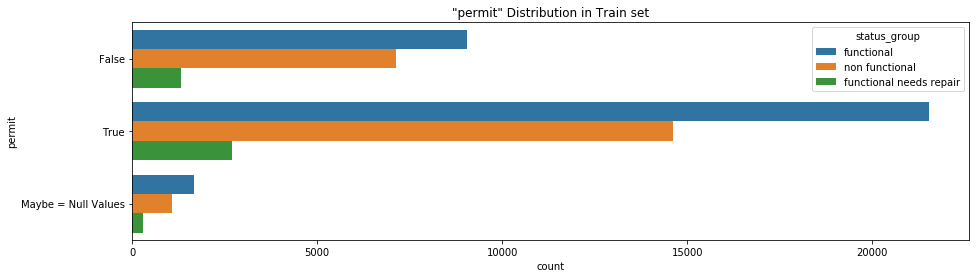

In [18]:
print('"permit" feature is consist of: '  ,list(set(data_train_test.permit)))
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y="permit", hue=data_train['status_group'], data= data_train[['permit']].fillna('Maybe = Null Values')).set_title('"permit" Distribution in Train set')

### I dropped the "recorded_by" column since it is comprised of onle 1 value.

In [19]:
print('"recorded_by" feature is consist of: '  ,list(set(data_train_test.recorded_by)))
data_train_test = data_train_test.drop(['recorded_by'], axis=1)

"recorded_by" feature is consist of:  ['GeoData Consultants Ltd']


## Data Skew
### For the Skewed features, I plot those features to get better understanding
#### As we can see, most of the values are near zero

Text(0.5,1,'amount_tsh Distribution - "amount_tsh"')

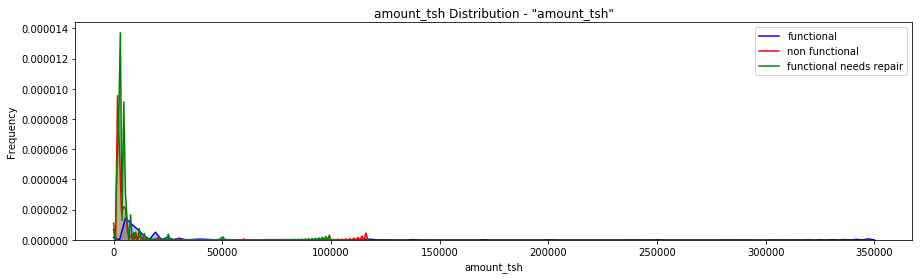

In [20]:
i = data_train.columns.get_loc("amount_tsh")
# Kernel Density Plot
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(data_train.loc[(data_train['status_group'] == 'functional'),data_train.columns[i]] , color='b',shade=True,label='functional')
ax=sns.kdeplot(data_train.loc[(data_train['status_group'] == 'non functional'),data_train.columns[i]] , color='r',shade=True, label='non functional')
ax=sns.kdeplot(data_train.loc[(data_train['status_group'] == 'functional needs repair'),data_train.columns[i]] , color='g',shade=True, label='functional needs repair')
ax.set(xlabel=data_train.columns[i], ylabel='Frequency')
plt.title( data_train.columns[i] + ' Distribution - "amount_tsh"')

Text(0.5,1,'num_private Distribution - "num_private"')

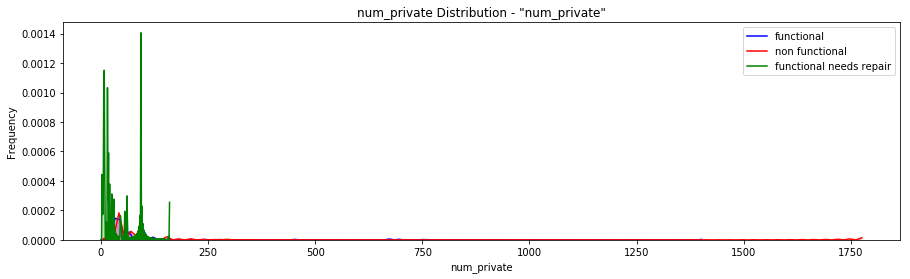

In [21]:
i = data_train.columns.get_loc("num_private")
# Kernel Density Plot
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(data_train.loc[(data_train['status_group'] == 'functional'),data_train.columns[i]] , color='b',shade=True,label='functional')
ax=sns.kdeplot(data_train.loc[(data_train['status_group'] == 'non functional'),data_train.columns[i]] , color='r',shade=True, label='non functional')
ax=sns.kdeplot(data_train.loc[(data_train['status_group'] == 'functional needs repair'),data_train.columns[i]] , color='g',shade=True, label='functional needs repair')
ax.set(xlabel=data_train.columns[i], ylabel='Frequency')
plt.title( data_train.columns[i] + ' Distribution - "num_private"')

### In the search for normality
- **Histogram** - Kurtosis and skewness.
- **Normal probability plot** - Data distribution should closely follow the diagonal that represents the normal distribution.

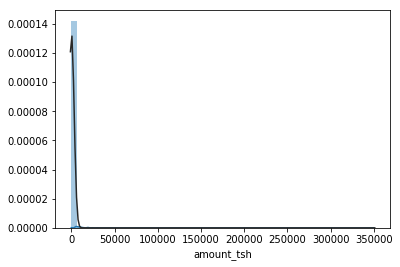

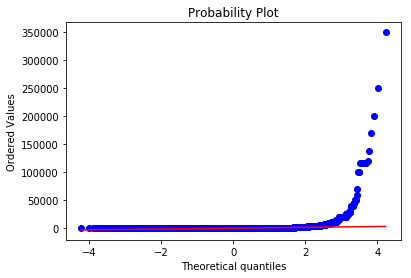

In [22]:
#histogram and normal probability plot
from scipy import stats
sns.distplot(data_train['amount_tsh'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(data_train['amount_tsh'], plot=plt)

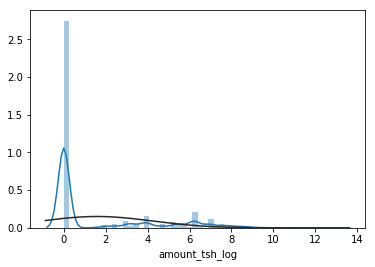

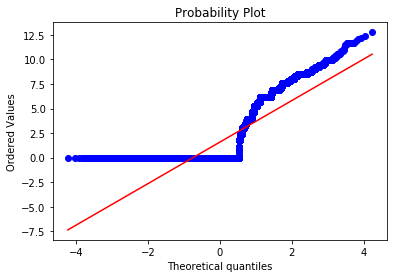

In [23]:
#applying log transformation
data_train['amount_tsh_log'] = (1+data_train['amount_tsh']).apply(np.log)

sns.distplot(data_train['amount_tsh_log'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(data_train['amount_tsh_log'], plot=plt)

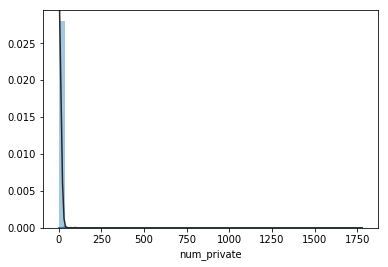

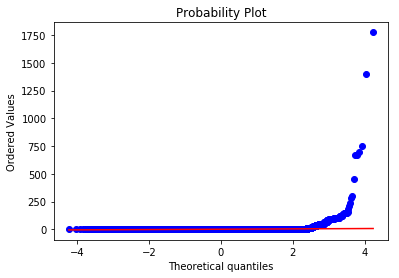

In [24]:
#histogram and normal probability plot
sns.distplot(data_train['num_private'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(data_train['num_private'], plot=plt)

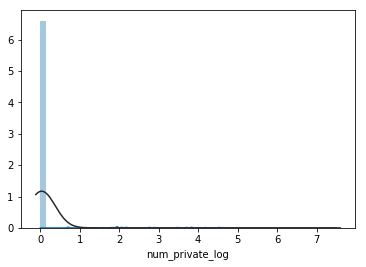

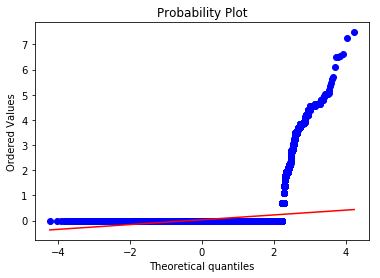

In [25]:
#applying log transformation
data_train['num_private_log'] = (1+data_train['num_private']).apply(np.log)

sns.distplot(data_train['num_private_log'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(data_train['num_private_log'], plot=plt)

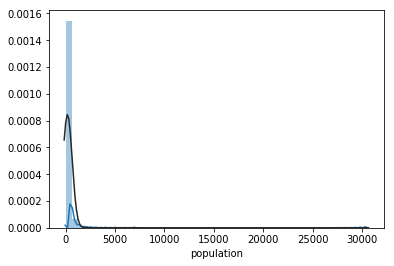

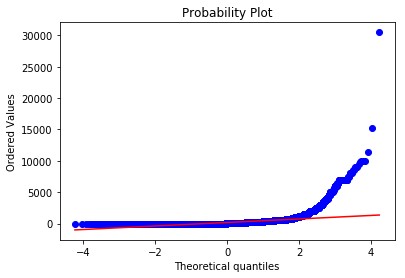

In [26]:
#histogram and normal probability plot
from scipy import stats
sns.distplot(data_train['population'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(data_train['population'], plot=plt)

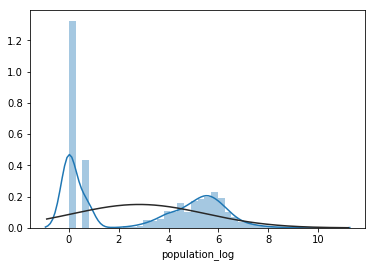

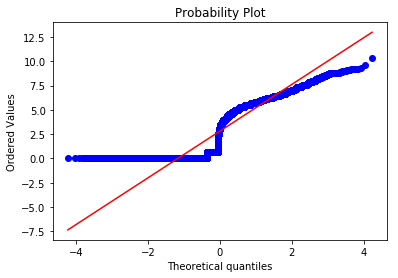

In [27]:
#applying log transformation
data_train['population_log'] = (1+data_train['population']).apply(np.log)

sns.distplot(data_train['population_log'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(data_train['population_log'], plot=plt)

### As we can see, by applying Log transform, the skenewss of "num_private", "amount_tsh", and "population" dropped heavily. 

In [28]:
df_skew = pd.DataFrame({'Column':data_train.skew().index, 'Skewness':data_train.skew().values, 'kurtosisness':data_train.kurtosis().values})
df_skew['sort'] = df_skew['Skewness'].abs()
df_skew.sort_values(by=['sort'] , ascending=False).drop('sort', axis=1)

,Column,Skewness,kurtosisness
5,num_private,91.933750,11137.295213
1,amount_tsh,57.807800,4903.543102
8,population,12.660714,402.280115
13,num_private_log,10.895630,128.246754
3,longitude,-4.191046,19.187031
7,district_code,3.962045,16.214284
6,region_code,3.173818,10.288433
9,public_meeting,-2.861945,6.190952
12,amount_tsh_log,1.337090,0.305070
10,permit,-0.819382,-1.328660


In [29]:
data_train_test = data_train_test.drop(['num_private', 'amount_tsh', 'population' ], axis=1)

In [30]:
for i in range(len(data_train_test.columns)):
    print("Number of distinct elements in %s is: %d \n"  % (data_train_test.columns[i], len(list(set(data_train_test.iloc[:,i])))) )

Number of distinct elements in id is: 74250 

Number of distinct elements in date_recorded is: 687 

Number of distinct elements in funder is: 2141 

Number of distinct elements in gps_height is: 2456 

Number of distinct elements in installer is: 2411 

Number of distinct elements in longitude is: 71870 

Number of distinct elements in latitude is: 71869 

Number of distinct elements in wpt_name is: 45684 

Number of distinct elements in basin is: 9 

Number of distinct elements in subvillage is: 21426 

Number of distinct elements in region is: 21 

Number of distinct elements in region_code is: 27 

Number of distinct elements in district_code is: 20 

Number of distinct elements in lga is: 125 

Number of distinct elements in ward is: 2098 

Number of distinct elements in public_meeting is: 3 

Number of distinct elements in scheme_management is: 13 

Number of distinct elements in permit is: 3 

Number of distinct elements in construction_year is: 55 

Number of distinct elements 

### Converting date column to 3 separate columns of year, month, and day 

In [31]:
data_train_test["year"] = pd.to_datetime(data_train_test["date_recorded"], errors='coerce').dt.year
data_train_test["month"] = pd.to_datetime(data_train_test["date_recorded"], errors='coerce').dt.month
data_train_test["day"] = pd.to_datetime(data_train_test["date_recorded"], errors='coerce').dt.day
data_train_test = data_train_test.drop(['date_recorded'], axis=1)

### Converting categorical features to numerical features using Label Encoding (suitalble for tree-based models)

In [32]:
le = LabelEncoder()
# data_train_test["funder"] = le.fit_transform(data_train_test["funder"])
# data_train_test["installer"] = le.fit_transform(data_train_test["installer"])
data_train_test["wpt_name"] = le.fit_transform(data_train_test["wpt_name"])
data_train_test["basin"] = le.fit_transform(data_train_test["basin"])
# data_train_test["subvillage"] = le.fit_transform(data_train_test["subvillage"])
data_train_test["region"] = le.fit_transform(data_train_test["region"])
data_train_test["lga"] = le.fit_transform(data_train_test["lga"])
data_train_test["ward"] = le.fit_transform(data_train_test["ward"])
data_train_test["public_meeting"] = le.fit_transform(data_train_test["public_meeting"])
# data_train_test["scheme_management"] = le.fit_transform(data_train_test["scheme_management"])
data_train_test["permit"] = le.fit_transform(data_train_test["permit"])
data_train_test["extraction_type"] = le.fit_transform(data_train_test["extraction_type"])
data_train_test["extraction_type_group"] = le.fit_transform(data_train_test["extraction_type_group"])
data_train_test["management"] = le.fit_transform(data_train_test["management"])
data_train_test["management_group"] = le.fit_transform(data_train_test["management_group"])
data_train_test["payment"] = le.fit_transform(data_train_test["payment"])
data_train_test["payment_type"] = le.fit_transform(data_train_test["payment_type"])
data_train_test["water_quality"] = le.fit_transform(data_train_test["water_quality"])
data_train_test["quality_group"] = le.fit_transform(data_train_test["quality_group"])
data_train_test["quantity"] = le.fit_transform(data_train_test["quantity"])
data_train_test["quantity_group"] = le.fit_transform(data_train_test["quantity_group"])
data_train_test["source"] = le.fit_transform(data_train_test["source"])
data_train_test["source_type"] = le.fit_transform(data_train_test["source_type"])
data_train_test["source_class"] = le.fit_transform(data_train_test["source_class"])
data_train_test["waterpoint_type"] = le.fit_transform(data_train_test["waterpoint_type"])
data_train_test["waterpoint_type_group"] = le.fit_transform(data_train_test["waterpoint_type_group"])
data_train_test["extraction_type_class"] = le.fit_transform(data_train_test["extraction_type_class"])

### Let's drop the columns that had problem for now, the columns that have special characters
### Dropping highly correlated columns absed on the result of pandas profiling

In [33]:
data_train_test = data_train_test.drop(['funder','installer','subvillage','scheme_management', 
                                        'extraction_type_group','quantity', 'source_type','waterpoint_type_group' ], axis=1)

## After the pre-processing, splitting into the train and test set 

In [34]:
data_train_modeling = data_train_test.iloc[0:data_train_label.shape[0]]

data_train_modeling = pd.merge(data_train_modeling, data_train_label, on=['id']) 

data_test_modeling = data_train_test.iloc[data_train_label.shape[0]:]

In [35]:
import warnings
warnings.filterwarnings('ignore')

import pandas_profiling
pandas_profiling.ProfileReport(data_train_test)

Number of variables,30
Number of observations,74250
Total Missing (%),0.0%
Total size in memory,17.0 MiB
Average record size in memory,240.0 B
Numeric,30
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


### Converting label column to numerical

In [36]:
data_train_modeling["status_group"] = le.fit_transform(data_train_modeling["status_group"])

# Now let's try the modeling -> Random forest

### Split dataset into %60 train set and %40 test set using Stratified Shuffle Split

In [37]:
y = data_train_modeling.status_group.values
x = data_train_modeling.drop(['status_group'], axis=1).values

kshuffle = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=seed)
for train_index, test_index in kshuffle.split(x, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((35640, 29), (23760, 29), (35640,), (23760,))

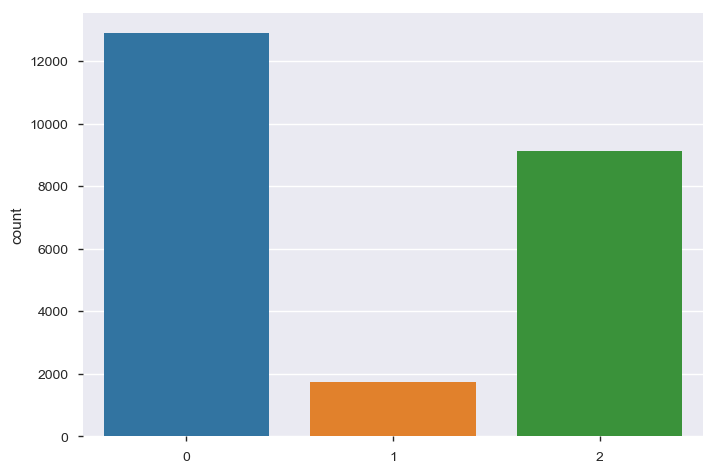

In [38]:
ax = sns.countplot(y_test , label = "Count")  
# data_train.groupby('status_group')['status_group'].count()

### Random search to find the best parameters

In [59]:
## randomized search to tune hyperparameters
# build a classifier
clf = RandomForestClassifier()
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": np.linspace(1, 32, 32, endpoint=True),
              "n_estimators":[8, 16, 24, 32, 40, 64, 80, 100, 120, 150, 200],
              "max_features": sp_randint(1, len(data_train_modeling.columns)),
              "min_samples_split": sp_randint(2, 30),
              "min_samples_leaf": sp_randint(1, 30),
              "bootstrap": [True, False],
              "class_weight": [None, 'balanced'],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 60
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, scoring = 'f1_weighted', 
                                   verbose = 1, n_iter=n_iter_search, random_state = 0, n_jobs  = 1)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
start = time()
random_search.fit(x_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 30.0min finished


RandomizedSearchCV took 1806.25 seconds for 60 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.778 (std: 0.001)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 22.0, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 24}

Model with rank: 2
Mean validation score: 0.773 (std: 0.001)
Parameters: {'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 28.0, 'max_features': 22, 'min_samples_leaf': 8, 'min_samples_split': 9, 'n_estimators': 80}

Model with rank: 3
Mean validation score: 0.773 (std: 0.002)
Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 17.0, 'max_features': 30, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 200}



In [53]:
## Test the best result for neg_log_loss

clf = RandomForestClassifier(bootstrap= True, criterion= 'entropy', max_depth= 16.0, max_features= 12, 
                             min_samples_leaf= 5, min_samples_split= 9, n_estimators= 200)
clf.fit(x_train, y_train)

y_score = clf.predict_proba(x_test)

y_pred = clf.predict(x_test)

In [48]:
## Test the best result for f1_micro

clf = RandomForestClassifier(bootstrap= True, criterion= 'entropy', max_depth= 16.0, max_features= 12, 
                             min_samples_leaf= 1, min_samples_split= 12, n_estimators= 24)
clf.fit(x_train, y_train)

y_score = clf.predict_proba(x_test)

y_pred = clf.predict(x_test)

In [41]:
## Test the best result for f1_weighted

clf = RandomForestClassifier(bootstrap= False, criterion= 'entropy', max_depth= 22.0, max_features= 10, 
                             min_samples_leaf= 1, min_samples_split= 12, n_estimators= 24)
clf.fit(x_train, y_train)

y_score = clf.predict_proba(x_test)

y_pred = clf.predict(x_test)

In [75]:
## Test the best result for accuracy

clf = RandomForestClassifier(bootstrap= False, criterion= 'entropy', max_depth= 22.0, max_features= 10, 
                             min_samples_leaf= 1, min_samples_split= 12, n_estimators= 24)
clf.fit(x_train, y_train)

y_score = clf.predict_proba(x_test)

y_pred = clf.predict(x_test)

In [136]:
## Test the best result for f1_weighted 2

clf = RandomForestClassifier(bootstrap= False, criterion= 'entropy', max_depth= 28.0, max_features= 22, 
                             min_samples_leaf= 8, min_samples_split= 9, n_estimators= 80)
clf.fit(x_train, y_train)

y_score = clf.predict_proba(x_test)

y_pred = clf.predict(x_test)

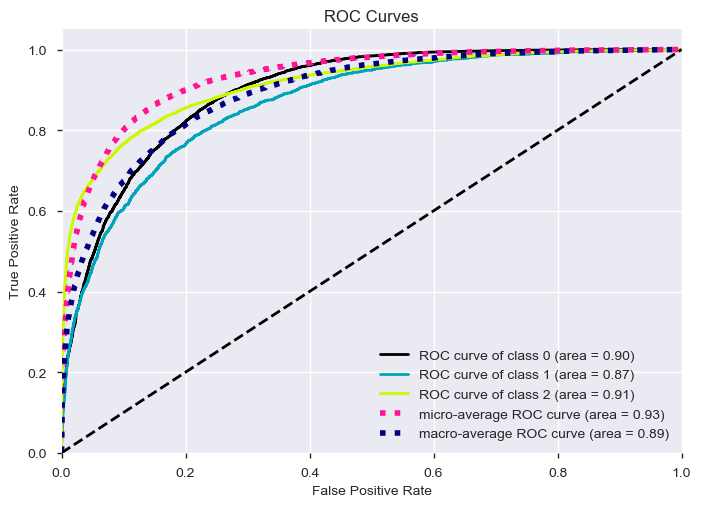

In [137]:
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, y_score)
plt.show()

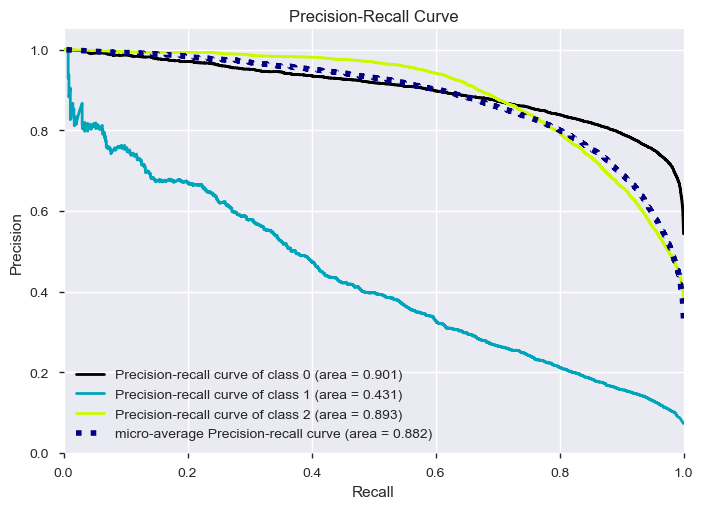

In [138]:
skplt.metrics.plot_precision_recall(y_test , y_score)
plt.show()

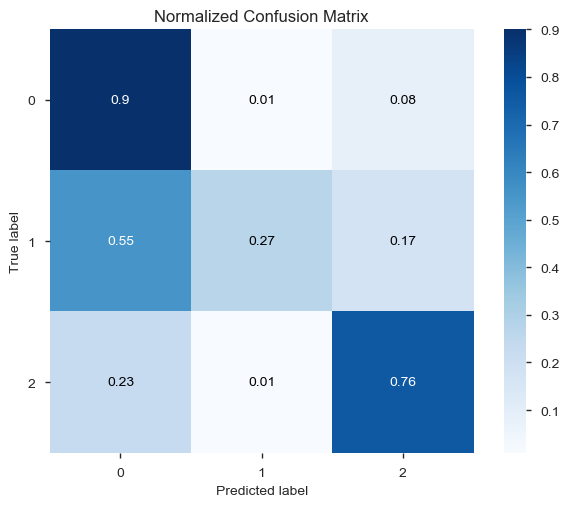

In [139]:
import scikitplot.plotters as skplt
skplt.plot_confusion_matrix(y_test, y_pred, normalize=True)

In [45]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.80      0.90      0.73      0.85      0.83      0.68     12903
          1       0.59      0.30      0.98      0.40      0.75      0.54      1727
          2       0.83      0.77      0.90      0.80      0.85      0.72      9130

avg / total       0.80      0.80      0.82      0.80      0.83      0.68     23760



#### Todo : 

- How to find special characters in a column
- dealing with results in data profiling

### XGBoost

In [108]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score

def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def f1(preds, dtrain):
    labels = dtrainn.get_label()
    return 'f1',  f1_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrainn.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrainn.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)

def BaseMetrics(y_pred,y_true):
    TP = np.sum( (y_pred == 1) & (y_true == 1) )
    TN = np.sum( (y_pred == 0) & (y_true == 0) )
    FP = np.sum( (y_pred == 1) & (y_true == 0) )
    FN = np.sum( (y_pred == 0) & (y_true == 1) )
    return TP, TN, FP, FN

def SimpleMetrics(y_pred,y_true):
    TP, TN, FP, FN = BaseMetrics(y_pred,y_true)
    ACC = ( TP + TN ) / ( TP + TN + FP + FN )
    
    # Reporting
    from IPython.display import display
    print( 'Confusion Matrix')
    display( pd.DataFrame( [[TN,FP],[FN,TP]], columns=['Pred 0','Pred 1'], index=['True 0', 'True 1'] ) )
    print( 'Accuracy : {}'.format( ACC ))
    
def SimpleAccuracy(y_pred,y_true):
    TP, TN, FP, FN = BaseMetrics(y_pred,y_true)
    ACC = ( TP + TN ) / ( TP + TN + FP + FN )
    return ACC

def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))

# precision-recall curve
def plot_precision_recall():
    plt.step(recall, precision, color = 'b', alpha = 0.2,
             where = 'post')
    plt.fill_between(recall, precision, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall, precision, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show();

# ROC curve
def plot_roc():
    plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 2)
    plt.plot([0,1],[0,1], 'k--', linewidth = 2)
    plt.xlim([0.0,0.001])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show();

In [128]:
from xgboost.sklearn import XGBClassifier

best iteration:  30


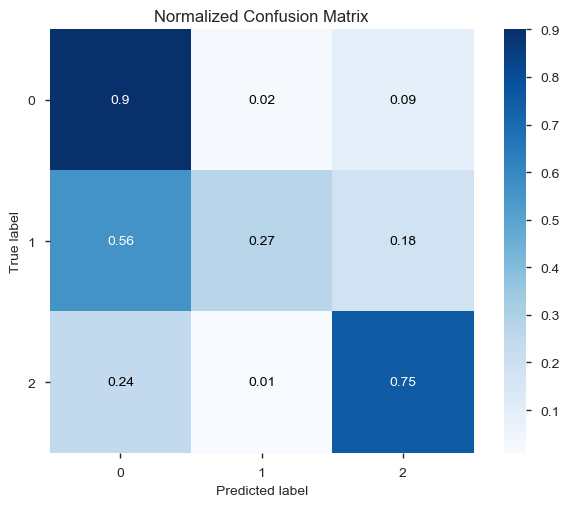

In [129]:
## xgboost
x_columns = data_train_modeling.drop(['status_group'], axis=1).columns

import xgboost as xgb
from sklearn.metrics import classification_report

dtrainn = xgb.DMatrix(x_train, y_train, feature_names=x_columns)
dvalidd = xgb.DMatrix(x_test, y_test, feature_names=x_columns)

results_dict = {}

xgb_params = {
     'max_depth': 12,
     'min_child_weight':7,
#     'colsample_bytree': 0.2,  if we want a high precision score (low FN value)
        'reg_alpha': 0.01,
    'objective': 'multi:softmax',
    'num_class': 3,
    'random_state': seed,
    'eval_metric': 'mlogloss', # auc, error, mlogloss, https://xgboost.readthedocs.io/en/latest/parameter.html
#     'tree_method': 'hist',
#     'grow_policy': 'lossguide' ,# depthwise, lossguide
    'class_weight': 'balanced'
}

xgb_test = xgb.train(xgb_params, dtrainn, num_boost_round=1000, 
                     verbose_eval=False,
                     early_stopping_rounds=4, 
                     evals=[(dtrainn,'train'),(dvalidd,'test')],
                     evals_result = results_dict,              
#                      feval = recall, maximize=True
#                      feval = roc_auc, maximize=True
                    )

y_pred = xgb_test.predict(dvalidd, ntree_limit=xgb_test.best_iteration+1)
y_true = y_test
print( 'best iteration: ', xgb_test.best_iteration )
import scikitplot.plotters as skplt
skplt.plot_confusion_matrix(y_test, y_pred, normalize=True)

In [133]:
## xgboost
x_columns = data_train_modeling.drop(['status_group'], axis=1).columns

import xgboost as xgb
from sklearn.metrics import classification_report

dtrainn = xgb.DMatrix(x_train, y_train, feature_names=x_columns)
dvalidd = xgb.DMatrix(x_test, y_test, feature_names=x_columns)

results_dict = {}

xgb_params = {
     'max_depth': 12,
     'min_child_weight':10,
#     'colsample_bytree': 0.2,  if we want a high precision score (low FN value)
        'reg_alpha': 0.01,
    'objective': 'multi:softmax',
    'num_class': 3,
    'random_state': seed,
    'eval_metric': 'mlogloss', # auc, error, mlogloss, https://xgboost.readthedocs.io/en/latest/parameter.html
#     'tree_method': 'hist',
#     'grow_policy': 'lossguide' ,# depthwise, lossguide
    'class_weight': 'balanced'
}

xgb_test = xgb.train(xgb_params, dtrainn, num_boost_round=1000, 
                     verbose_eval=False,
                     early_stopping_rounds=40, 
                     evals=[(dtrainn,'train'),(dvalidd,'test')],
                     evals_result = results_dict,              
#                      feval = recall, maximize=True
#                      feval = roc_auc, maximize=True
                    )

y_pred = xgb_test.predict(dvalidd, ntree_limit=xgb_test.best_iteration+1)
y_true = y_test
print( 'best iteration: ', xgb_test.best_iteration )


best iteration:  39


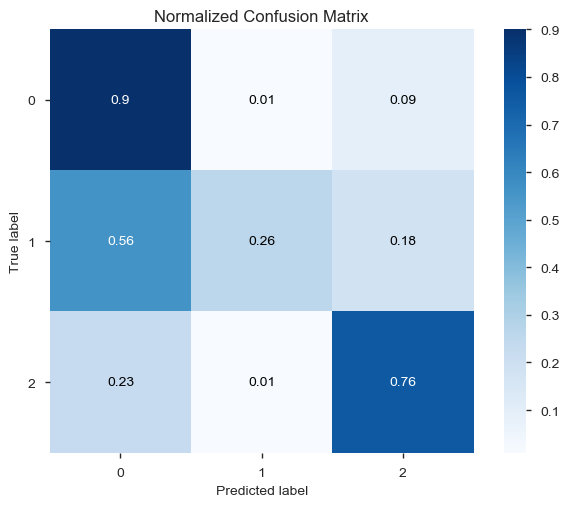

In [134]:
import scikitplot.plotters as skplt
skplt.plot_confusion_matrix(y_test, y_pred, normalize=True)

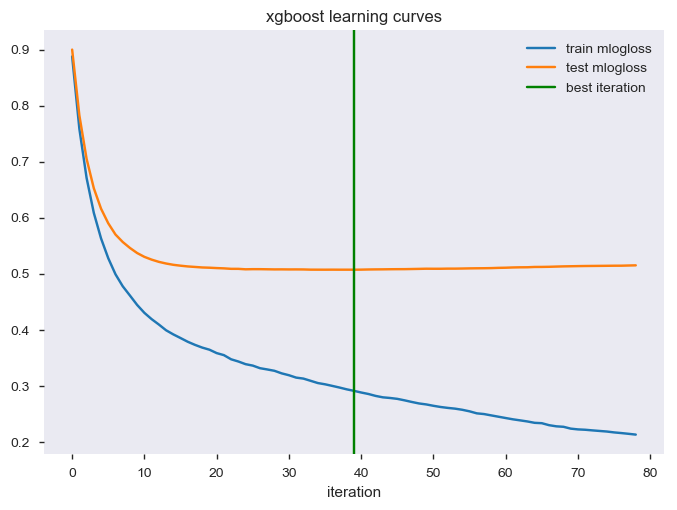

In [135]:
# Let's look at how the metrics changed on the train and test sets as more trees were added

for i in results_dict:
    for err in results_dict[i]:
        plt.plot(results_dict[i][err], label=i+' '+err)   
plt.axvline(xgb_test.best_iteration, c='green', label='best iteration')
plt.xlabel('iteration')
# plt.ylabel(err)
plt.title('xgboost learning curves')
plt.legend()
plt.grid() ;

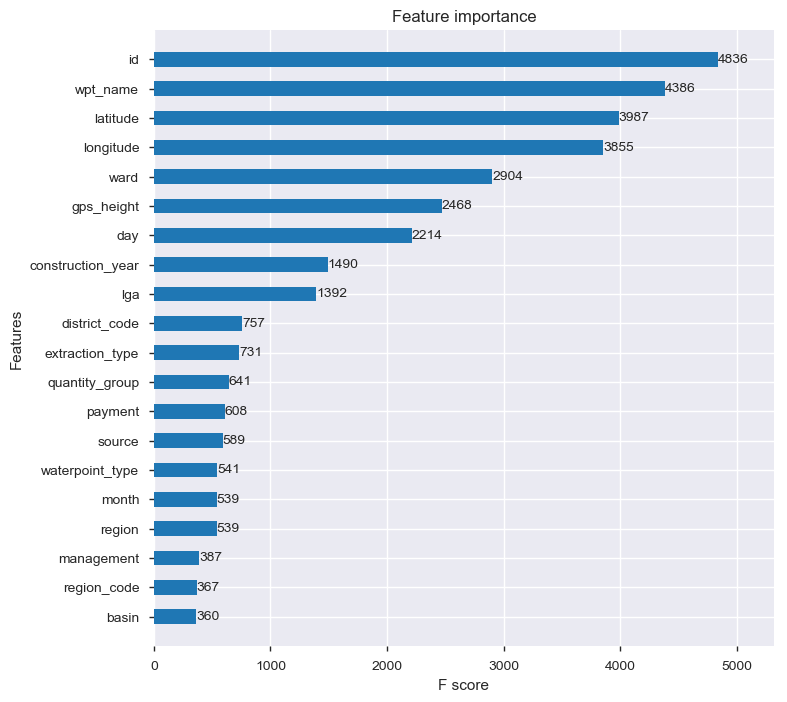

In [113]:
# Plot feature importances

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=20, height=0.5, ax=ax);